In [1]:
import sys
sys.path.append('../code')

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import torch
from sklearn.model_selection import ShuffleSplit
import pickle
from scipy.signal import savgol_filter
from sklearn.model_selection import StratifiedShuffleSplit
from functools import partial
from scipy import stats


# CUDA for PyTorch
use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0")
#device = torch.device('cpu')

torch.backends.cudnn.benchmark = True

import contrastive_functions

In [2]:
# Prepare dataframes for movement decoding
def get_marker_decode_dataframes(noise_fold=0):
    cam_idx = 1
    # kinematic_df, neural_df, metadata = mocap_functions.load_mocap_df('../data/SPK20220308/task_data/', kinematic_suffix=f'_cam{cam_idx}')
    kinematic_df, neural_df, metadata = contrastive_functions.load_mocap_df('../data/SPK20220308/task_data/', kinematic_suffix=f'_cam{cam_idx}')

    num_trials = len(kinematic_df['trial'].unique())

    pos_filter = [1,2,3,4]
    layout_filter = [1,2,3,4]
    pos_remove_filter = [f'position_{pos_idx}' for pos_idx in []]
    layout_remove_filter = [f'layout_{layout_idx}' for layout_idx in []]

    # pos_filter = [1, 4]
    # layout_filter = [1,2]
    # pos_remove_filter = [f'position_{pos_idx}' for pos_idx in [2,3]]
    # layout_remove_filter = [f'layout_{layout_idx}' for layout_idx in [3,4]]


    neural_df = neural_df[np.in1d(neural_df['position'], pos_filter)].reset_index(drop=True)
    neural_df = neural_df[np.in1d(neural_df['layout'], layout_filter)].reset_index(drop=True)
    neural_df = neural_df[~np.in1d(neural_df['unit'], pos_remove_filter)].reset_index(drop=True)
    neural_df = neural_df[~np.in1d(neural_df['unit'], layout_remove_filter)].reset_index(drop=True)

    kinematic_df = kinematic_df[np.in1d(kinematic_df['position'], pos_filter)].reset_index(drop=True)
    kinematic_df = kinematic_df[np.in1d(kinematic_df['layout'], layout_filter)].reset_index(drop=True)
    kinematic_df = kinematic_df[~np.in1d(kinematic_df['name'], pos_remove_filter)].reset_index(drop=True)
    kinematic_df = kinematic_df[~np.in1d(kinematic_df['name'], layout_remove_filter)].reset_index(drop=True)

    # Subselect specific marker
    marker_list = ['indexProx', 'thumbProx', 'ringProx', 'carpal', 'pinkyProx', 'middleProx', 'layout', 'time'] # cam4
    # marker_list = ['ringProx', 'time'] # cam4
    # marker_list = ['ringProx', 'thumbProx'] # cam4
    # marker_list = ['indexProx', 'carpal', 'ringProx'] # cam1

    mask_list = [kinematic_df['name'].str.contains(pat=pat) for pat in marker_list]
    wrist_df = kinematic_df[np.logical_or.reduce(mask_list)]

    # Remove trials with velocity outliers
    velocity_outlier_thresh = 10
    velocity_std = np.concatenate(wrist_df['posData'].map(np.diff).values).std()
    velocity_outlier_mask = wrist_df['posData'].map(np.diff).apply(
        lambda x: np.any(np.abs(x - np.mean(x)) > velocity_outlier_thresh * velocity_std))
    velocity_outlier_trials = wrist_df[velocity_outlier_mask]['trial'].unique()

    wrist_df = wrist_df[wrist_df['trial'].apply(lambda x: x not in velocity_outlier_trials)]
    neural_df = neural_df[neural_df['trial'].apply(lambda x: x not in velocity_outlier_trials)]

    # Remove trials with length outliers
    length_outlier_thresh = 10
    trial_lengths = wrist_df['posData'].map(len).values
    length_outlier_mask = np.abs(trial_lengths - np.mean(trial_lengths)) > length_outlier_thresh * np.std(trial_lengths)
    length_outlier_trials = wrist_df[length_outlier_mask]['trial'].unique()

    wrist_df = wrist_df[wrist_df['trial'].apply(lambda x: x not in length_outlier_trials)]
    neural_df = neural_df[neural_df['trial'].apply(lambda x: x not in length_outlier_trials)]

    assert np.array_equal(neural_df['trial'].unique(), wrist_df['trial'].unique())

    trial_ids = neural_df['trial'].unique()
    num_trials_filtered = len(trial_ids)

    # Give each layout/position combination a unique label
    trial_type_dict = dict()
    label_idx = 0
    for layout_idx in range(1,5):
        for position_idx in range(1,5):
            trial_type_dict[(layout_idx, position_idx)] = label_idx
            label_idx = label_idx + 1

    # Populate list with labels to match each trials
    trial_labels = list()
    for trial_id in trial_ids:
        layout_idx = neural_df[neural_df['trial'] == trial_id]['layout'].values[0]
        position_idx = neural_df[neural_df['trial'] == trial_id]['position'].values[0]
        trial_labels.append(trial_type_dict[(layout_idx, position_idx)])
    trial_labels = np.array(trial_labels)

    

    #Generate cv_dict for regular train/test/validate split (no rolling window)
    # cv_split = StratifiedShuffleSplit(n_splits=5, test_size=.25, random_state=3)
    # val_split = StratifiedShuffleSplit(n_splits=1, test_size=.25, random_state=3)

    cv_split = StratifiedShuffleSplit(n_splits=10, test_size=0.5, random_state=3)
    val_split = StratifiedShuffleSplit(n_splits=1, test_size=0.5, random_state=3)

    cv_dict = {}
    for fold, (train_val_idx, test_idx) in enumerate(cv_split.split(trial_ids, trial_labels)):
        val_trial_labels = trial_labels[train_val_idx]
        for t_idx, v_idx in val_split.split(train_val_idx, val_trial_labels): #No looping, just used to split train/validation sets
            cv_dict[fold] = {'train_idx':trial_ids[train_val_idx[t_idx]], 
                            'test_idx':trial_ids[test_idx], 
                            'validation_idx':trial_ids[train_val_idx[v_idx]]} 

    neural_df, wrist_df = contrastive_functions.add_noise(neural_df, wrist_df, cv_dict, noise_fold, num_trials, neural_noise=1, kinematic_noise=10)

    # Smooth everything after adding noise
    smooth_func = partial(savgol_filter, window_length=31, polyorder=3)
    neural_df['rates'] = neural_df['rates'].map(smooth_func)
    wrist_df['posData'] = wrist_df['posData'].map(smooth_func)

    nolayout_neural_mask = ~(neural_df['unit'].str.contains(pat='layout'))
    noposition_neural_mask = ~(neural_df['unit'].str.contains(pat='position'))
    notask_neural_df = neural_df[np.logical_and.reduce([nolayout_neural_mask, noposition_neural_mask])]
    task_neural_df = neural_df.copy()


    nolayout_wrist_mask = ~(wrist_df['name'].str.contains(pat='layout'))
    noposition_wrist_mask = ~(wrist_df['name'].str.contains(pat='position'))
    notask_wrist_df = wrist_df[np.logical_and.reduce([nolayout_wrist_mask, noposition_wrist_mask])]
    task_wrist_df = wrist_df.copy()

    data_dict = {'task_wrist_df': task_wrist_df, 'notask_wrist_df': notask_wrist_df,'task_neural_df': task_neural_df, 'notask_neural_df': notask_neural_df,
                 'metadata': metadata, 'cv_dict': cv_dict, 'noise_fold': noise_fold, 'kinematic_df':kinematic_df}
    return data_dict

In [3]:
noise_fold = 0
data_dict = get_marker_decode_dataframes(noise_fold = noise_fold)
task_wrist_df = data_dict['task_wrist_df']
notask_wrist_df = data_dict['notask_wrist_df']
task_neural_df = data_dict['task_neural_df']
notask_neural_df = data_dict['notask_neural_df']
metadata = data_dict['metadata']
cv_dict = data_dict['cv_dict']

neuron_list = notask_neural_df['unit'].unique()

/home/nick/Donoghue_lab/ncm_2023/notebooks/../code/contrastive_functions.py:332: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  neural_temp_df['rates'][unit_mask] = noise_data
/home/nick/Donoghue_lab/ncm_2023/notebooks/../code/contrastive_functions.py:346: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  wrist_temp_df['posData'][unit_mask] = noise_data
/home/nick/Donoghue_lab/ncm_2023/notebooks/../code/contrastive_functions.py:332: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing

In [4]:
notask_time_neural_mask = notask_neural_df['unit'] != 'time'
notask_neural_df = notask_neural_df[notask_time_neural_mask]

# notask_time_wrist_mask = notask_wrist_df['name'] != 'time'
# notask_wrist_df = notask_wrist_df[notask_time_wrist_mask]

In [5]:
neural_offset = 2 # try 50-150 ms offset
window_size = 70
label_col = 'layout'
temperature = 2
dropout = 0.2

In [6]:
# func_dict = {'wiener': contrastive_functions.run_wiener, 'rnn': contrastive_functions.run_rnn}
func_dict = {'rnn': contrastive_functions.run_rnn}
fpath = '../data/SPK20220308/neuron_num_results/'

num_repeats = 1
# num_neuron_list = np.arange(2,51,4)
# num_neuron_list = [2,4,6,10,15,20]

results_dict = {'moise_fold': noise_fold}

for dropout in [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8]:
    for temperature in [0.1, 0.2, 0.5, 1, 2, 5, 7, 10, 15, 20]:

        df_dict = {'task': {'df': task_wrist_df, 'task_info': True, 'num_cat': 0, 'flip_outputs': False,
                            'dropout': dropout,'temperature': temperature}, # num_cat = number of categorical features
                    'notask': {'df': notask_wrist_df, 'task_info': False, 'num_cat': 0, 'flip_outputs': False,
                                'dropout': dropout}}


        decode_results = dict()
        for func_name, func in func_dict.items():
            decode_results[func_name] = dict()
            for df_type, pred_df in df_dict.items():
                print(f'{func_name}_{df_type}; temperature_{temperature}; dropout_{dropout}')

                model, res_dict = func(pred_df['df'], notask_neural_df, neural_offset, cv_dict, metadata, task_info=pred_df['task_info'],
                                        window_size=window_size, num_cat=pred_df['num_cat'], label_col=label_col, flip_outputs=pred_df['flip_outputs'],
                                        temperature=temperature)

                decode_results[func_name][df_type] = res_dict

                # Save results on every loop in case early stop
                results_dict[f'temperature_{temperature}; dropout_{dropout}'] = decode_results

                # #Save metadata
                # output = open(f'{fpath}sua_prediction_fold0_neurons300_nocontrast.pkl', 'wb')
                # pickle.dump(results_dict, output)
                # output.close()




rnn_task; temperature_5; dropout_0
******....
Epoch: 10/1000 ... Train Loss: 0.6787  ... Validation Loss: 0.9218
.. Early Stop; Min Epoch: 6
rnn_notask; temperature_5; dropout_0
*******.*.
Epoch: 10/1000 ... Train Loss: 0.7338  ... Validation Loss: 0.8931
..... Early Stop; Min Epoch: 9
rnn_task; temperature_5; dropout_0.1
*****.....
Epoch: 10/1000 ... Train Loss: 0.6649  ... Validation Loss: 0.9214
. Early Stop; Min Epoch: 5
rnn_notask; temperature_5; dropout_0.1
*******...
Epoch: 10/1000 ... Train Loss: 0.7306  ... Validation Loss: 0.8919
... Early Stop; Min Epoch: 7
rnn_task; temperature_5; dropout_0.2
******....
Epoch: 10/1000 ... Train Loss: 0.6659  ... Validation Loss: 0.9137
.. Early Stop; Min Epoch: 6
rnn_notask; temperature_5; dropout_0.2
******....
Epoch: 10/1000 ... Train Loss: 0.7091  ... Validation Loss: 0.9082
.. Early Stop; Min Epoch: 6
rnn_task; temperature_5; dropout_0.3
******.*..
Epoch: 10/1000 ... Train Loss: 0.6746  ... Validation Loss: 0.9183
.... Early Stop; Min E

(-0.05, 0.9)

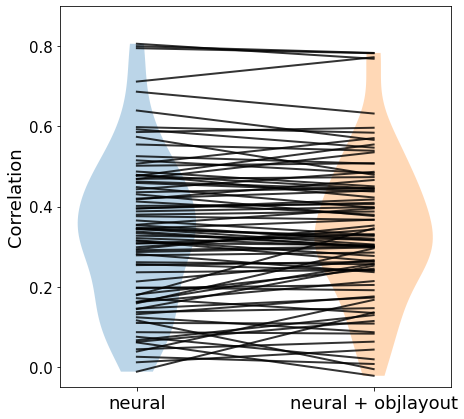

In [7]:
decoder_type = 'rnn'
cond1, cond2 = 'notask', 'task'

labelsize=18
ticksize=15

nolayout_test_corr = decode_results[decoder_type][cond1]['test_corr']
all_test_corr = decode_results[decoder_type][cond2]['test_corr']

plt.figure(figsize=(7,7))

plot_data = np.stack([nolayout_test_corr, all_test_corr])
_ = plt.plot(plot_data, color='k', linewidth=2, alpha=0.8)
plt.xticks([0, 1], labels=['neural', 'neural + objlayout'], fontsize=labelsize)
plt.yticks(fontsize=ticksize)
plt.ylabel('Correlation', fontsize=labelsize)
plt.violinplot(nolayout_test_corr, positions=[0], showmeans=False,showextrema=False)
plt.violinplot(all_test_corr, positions=[1], showmeans=False,showextrema=False)
# plt.title('All Marker Decoding', fontsize=16)
plt.ylim([-0.05,0.9])
# plt.savefig(f'sua_prediction_violin.svg')

(array([ 0.,  2.,  4.,  6.,  8., 10., 12., 14., 16.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

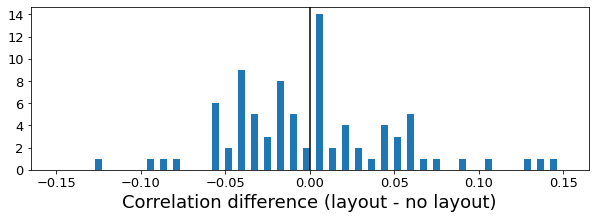

In [8]:
corr_diff = all_test_corr - nolayout_test_corr

ticksize=13
plt.figure(figsize=(10,3))
bins=np.linspace(-0.15, 0.15, 40)
_ = plt.hist(corr_diff, bins=bins, width=0.004)
plt.axvline(x=0, color='k')
plt.xlabel('Correlation difference (layout - no layout)', fontsize=labelsize)
plt.xticks(fontsize=ticksize)
plt.yticks(fontsize=ticksize)
# plt.savefig('sua_prediction_histogram.svg')

In [9]:
stats.ttest_1samp(corr_diff, popmean=0, alternative='greater')

Ttest_1sampResult(statistic=0.8083688969132022, pvalue=0.21055439718375069)

In [10]:
data_arrays, generators = contrastive_functions.make_generators(
    notask_wrist_df, notask_neural_df, neural_offset, cv_dict, metadata, exclude_neural=None,
    window_size=window_size, flip_outputs=False, batch_size=1000, label_col='layout')

training_set, validation_set, testing_set = data_arrays
training_generator, training_eval_generator, validation_generator, testing_generator = generators

X_train_data = training_set[:][0][:,-1,:].detach().cpu().numpy()
y_train_data = training_set[:][1][:,-1,:].detach().cpu().numpy()

X_test_data = testing_set[:][0][:,-1,:].detach().cpu().numpy()
y_test_data = testing_set[:][1][:,-1,:].detach().cpu().numpy()

test_labels = testing_set[:][2].detach().cpu().numpy()

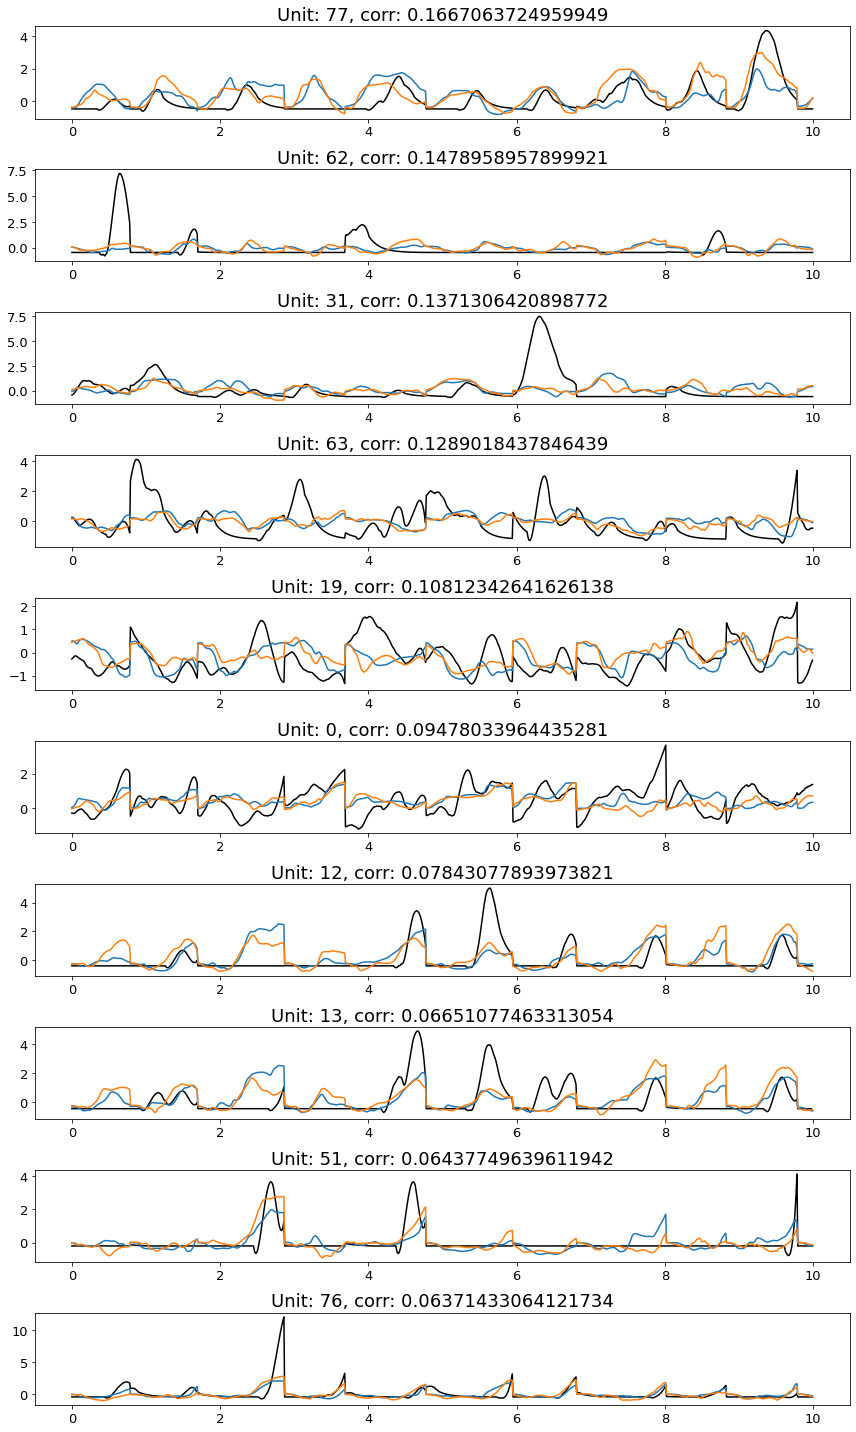

In [11]:
# Good units: [26, 47, 53, 13]
unit_sort = np.argsort(corr_diff)[::-1]
# unit_sort = np.argsort(all_test_corr)[::-1]

time_offset = 0

bounds = list(range(0+time_offset,1000+time_offset))
x_times = np.arange(len(bounds)) / 100 # Sampling rate=100 Hz

offset = 0
plt.figure(figsize=(12,20))
for plot_idx, sort_idx in enumerate(range(offset, offset+10)):
    unit_idx = unit_sort[sort_idx]
    plt.subplot(10,1,plot_idx+1)
    plt.plot(x_times, y_test_data[bounds,unit_idx], color='k')
    plt.plot(x_times, decode_results['rnn']['notask']['test_pred'][bounds,unit_idx])
    plt.plot(x_times, decode_results['rnn']['task']['test_pred'][bounds,unit_idx])
    plt.xticks(fontsize=ticksize)
    plt.yticks(fontsize=ticksize)
    plt.title(f'Unit: {unit_idx}, corr: {corr_diff[unit_idx]}', fontsize=labelsize)
    plt.tight_layout()

